In [1]:
import os
import sys

import underworld as uw
from underworld import function as fn
from underworld.scaling import units as u
from underworld.scaling import dimensionalise as dm, non_dimensionalise as nd
import glucifer
import numpy as np
import collections
import xml.etree.ElementTree as elementTree

In [14]:
# turnables
wholeMantleFlag = False
airLayer = True
gldbFlag = False
# restartFlag = True
outputDirName = "AnnSubBenchmark_SA_Lo_dot001_T333"
# outputDirName = "T_SA_Lo_dot001"

In [15]:
outputDir = os.path.join(os.path.abspath("."), outputDirName + "/")
if uw.mpi.rank == 0:
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)
uw.mpi.barrier()
checkpointedSteps = np.sort(
    np.unique(
        np.array(
            [
                int(os.path.splitext(filename)[0].split("-")[-1])
                for filename in os.listdir(outputDir)
                if "-" in filename
            ]
        )
    )
)

restartFlag = True if checkpointedSteps.shape[0] > 0 else False
step = checkpointedSteps[-1] if restartFlag else 0

if step > 0:
    dmTime = (
        elementTree.parse(outputDir + "velocity" + "-" + str(step).zfill(5) + ".xdmf")
        .getiterator("Time")[0]
        .get("Value")
    )
else:
    dmTime = 0

In [16]:

# Scaling and Units
#
# Dimentional Parameters
airHeight = 50.0 * u.kilometer if airLayer else 0.0 * u.kilometer
modelHeight = 2891 * u.kilometer if wholeMantleFlag else 1000.0 * u.kilometer
earthRadius = 6371 * u.kilometer
modelCartAspect = 2 if wholeMantleFlag else 4
ThetaRAD = np.rad2deg((modelHeight * modelCartAspect) / earthRadius)

# plateHeight = 120. * u.kilometer
refDensity = 3200.0 * u.kilogram / u.meter ** 3
deltaRhoMax = 80.0 * u.kilogram / u.meter ** 3
gravity = 9.8 * u.metre / u.second ** 2
# 1.57e20 * u.pascal * u.second 5.e20 * u.pascal * u.second
refViscosity = 5.0e20 * u.pascal * u.second
bodyForce = refDensity * gravity

# scaling coefficients
K_eta = refViscosity
KL = modelHeight
K_tau = bodyForce * modelHeight
K_v = K_tau * modelHeight / K_eta
# Kt = KL/K_v
Kt = K_eta / K_tau
KM = K_tau * modelHeight * Kt ** 2

scaling_coefficients = uw.scaling.get_coefficients()

scaling_coefficients["[length]"] = KL.to_base_units()
# scaling_coefficients["[temperature]"] = KT.to_base_units()
scaling_coefficients["[time]"] = Kt.to_base_units()
scaling_coefficients["[mass]"] = KM.to_base_units()

In [17]:
dmTime = float(dmTime)
step = int(step)
time = nd(dmTime * 1.0 * u.megayear)
maxSteps = 2000

try:
    tflag = os.environ["UW_ENABLE_TIMING"]
except KeyError:
    tflag = False
else:
    if tflag == "1":
        tflag = True
    else:
        tflag = False
uw.mpi.barrier()
if tflag:
    uw.timing.start()

In [18]:
mesh = uw.mesh.FeMesh_Annulus(
    elementRes=(int(192/4), int(384/4)),
    radialLengths=(nd(earthRadius - modelHeight + airHeight), nd(earthRadius)),
    angularExtent=((180 - ThetaRAD.magnitude) / 2, 90 + ThetaRAD.magnitude / 2),
    periodic=[False, False],
)


velocityField = mesh.add_variable(nodeDofCount=mesh.dim)
pressureField = mesh.subMesh.add_variable(nodeDofCount=1)
viscosityField = mesh.add_variable(1)


In [101]:
mesh.angularExtent

(72.013567881625391, 107.98643211837461)

In [104]:
107/2-72/2

17.5

In [19]:
swarm = uw.swarm.Swarm(mesh, particleEscape=True)
materialVariable = swarm.add_variable(count=1, dataType="int")
layout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm, particlesPerCell=20)
if restartFlag is False:
    swarm.populate_using_layout(layout)
advector = uw.systems.SwarmAdvector(velocityField=velocityField, swarm=swarm)
swarm_popcontrol = uw.swarm.PopulationControl(
    swarm,
    deleteThreshold=0.0025,
    splitThreshold=0.10,
    maxDeletions=0,
    maxSplits=100,
    aggressive=True,
    aggressiveThreshold=0.95,
    particlesPerCell=20,
)


In [20]:

def checkpoint(
    mesh,
    fieldDict,
    swarm,
    swarmDict,
    index,
    modeltime=None,
    meshName="mesh",
    swarmName="swarm",
    prefix="./",
    enable_xdmf=True,
    load=False,
):
    # Check the prefix is valid
    if prefix is not None:
        if not prefix.endswith("/"):
            prefix += "/"  # add a backslash
        if not os.path.exists(prefix) and uw.mpi.rank == 0:
            print("Creating directory: ", prefix)
            os.makedirs(prefix)

    if not isinstance(index, int):
        raise TypeError("'index' is not of type int")
    if modeltime is not None:
        time = modeltime
    else:
        time = index

    ii = str(index).zfill(5)

    if mesh is not None:

        # Error check the mesh and fields
        if not isinstance(mesh, uw.mesh.FeMesh):
            raise TypeError("'mesh' is not of type uw.mesh.FeMesh")
        if fieldDict is not None:
            if not isinstance(fieldDict, dict):
                raise TypeError("'fieldDict' is not of type dict")
            for key, value in fieldDict.items():
                if not isinstance(value, uw.mesh.MeshVariable):
                    raise TypeError(
                        "'fieldDict' must contain uw.mesh.MeshVariable elements"
                    )

        # see if we have already saved the mesh. It only needs to be saved once
        if not hasattr(checkpoint, "mH"):
            if load:
                if uw.mpi.rank == 0:
                    print("Loading Mesh.....")
                    sys.stdout.flush()
                mesh.load(prefix + meshName + ".h5")
            if uw.mpi.rank == 0:
                print("Saving Mesh.....")
                sys.stdout.flush()
            checkpoint.mH = mesh.save(prefix + meshName + ".h5")
        mh = checkpoint.mH

        for key, value in fieldDict.items():
            filename = prefix + key + "-" + ii
            if load:
                if uw.mpi.rank == 0:
                    print("Loading MeshVariable(s).....")
                if uw.mpi.rank == 0:
                    print("Loading '{0}.h5' .....".format(filename))
                value.load(filename + ".h5")
            else:
                handle = value.save(filename + ".h5")
                if enable_xdmf:
                    value.xdmf(filename, handle, key, mh, meshName, modeltime=time)

    # is there a swarm
    if swarm is not None:

        # Error check the swarms
        if not isinstance(swarm, uw.swarm.Swarm):
            raise TypeError("'swarm' is not of type uw.swarm.Swarm")
        if swarmDict is not None:
            if not isinstance(swarmDict, dict):
                raise TypeError("'swarmDict' is not of type dict")
            for key, value in swarmDict.items():
                if not isinstance(value, uw.swarm.SwarmVariable):
                    raise TypeError(
                        "'SwarmDict' must contain uw.swarm.SwarmVariable elements"
                    )
        if load:
            if uw.mpi.rank == 0:
                print("Loading Swarm.....")
                sys.stdout.flush()
            swarm.load(prefix + swarmName + "-" + ii + ".h5")
        else:
            if uw.mpi.rank == 0:
                print("Saving Swarm.....")
                sys.stdout.flush()
            sH = swarm.save(prefix + swarmName + "-" + ii + ".h5")
        for key, value in swarmDict.items():
            filename = prefix + key + "-" + ii
            if load:
                if uw.mpi.rank == 0:
                    print("Loading SwarmVariable(s).....")
                    if uw.mpi.rank == 0:
                        print("Loading '{0}.h5' .....".format(filename))
                value.load(filename + ".h5")
            else:
                handle = value.save(filename + ".h5")
                if enable_xdmf:
                    value.xdmf(filename, handle, key, sH, swarmName, modeltime=time)
    if uw.mpi.rank == 0:
        print("Done.....")
        sys.stdout.flush()

In [21]:
fieldDict = collections.OrderedDict()  # important to avoid racing conditions
fieldDict["velocity"] = velocityField
fieldDict["pressure"] = pressureField
fieldDict["meshViscosity"] = viscosityField

swarmDict = collections.OrderedDict()
swarmDict["materials"] = materialVariable
# traceDict = {"tcoords": tincord, "tvel": tracerVelocity}
refieldDict = collections.OrderedDict()  # important to avoid racing conditions
refieldDict["velocity"] = velocityField
refieldDict["pressure"] = pressureField


In [22]:
if restartFlag is True:
    checkpoint(
        mesh,
        refieldDict,
        swarm,
        swarmDict,
        index=step,
        modeltime=dm(time, 1.0 * u.megayear).magnitude,
        prefix=outputDir,
        load=True,
    )
store = glucifer.Store(outputDir + "/gfxstore") if gldbFlag is True else None
if store is not None:
    store.step = 0

In [23]:
fig = glucifer.Figure(store=None, figsize=(1200, 450))
# fig.append( glucifer.objects.Mesh( mesh ,nodeNumbers=True))
fig.append(glucifer.objects.Mesh(mesh))
# fig.append( glucifer.objects.Points( swarm,pointsize=4))
fig.save(outputDir + "/mesh")


radialFn = fn.math.sqrt(fn.math.dot(fn.coord(), fn.coord()))
thetaFn = fn.math.atan2(fn.coord()[1], fn.coord()[0])

In [24]:
class LayerCircle(fn.Function):
    """Layer Circle"""

    def __init__(self, c1, c2, r1, r2):
        """Create an Layer with two Circles
        Parameters
        ----------
        c1 : center of Internal Circle
        c2 : center of External Circle
        r1 : Internal radius
        r2 : External radius
        Returns
        -------
        An Underworld function(fn) object
        """
        self.r1 = r1
        self.r2 = r2

        coord1 = fn.input() - c1
        coord2 = fn.input() - c2
        self._fn = (fn.math.dot(coord2, coord2) < r2 ** 2) & (
            fn.math.dot(coord1, coord1) > r1 ** 2
        )
        super(LayerCircle, self).__init__(argument_fns=None)
        self._fncself = self._fn._fncself

In [28]:
class sideofCircle(fn.Function):
    """Layer Circle"""

    def __init__(self, c1, r1):
        """Create an Layer with two Circles
        Parameters
        ----------
        c1 : center of Internal Circle
        c2 : center of External Circle
        r1 : Internal radius
        r2 : External radius
        Returns
        -------
        An Underworld function(fn) object
        """
        self.r1 = r1
        self.r2 = r2

        coord1 = fn.input() - c1
        self._fn = fn.math.dot(coord1, coord1) > r1 ** 2
        super(sideofCircle, self).__init__(argument_fns=None)
        self._fncself = self._fn._fncself

In [117]:
# SH*T GETS REAL HERE

if restartFlag is False:

    air = mesh.unit_heightFn.evaluate(swarm.data) > nd(modelHeight - airHeight)
    lowermantle = mesh.unit_heightFn.evaluate(swarm.data) < nd(
        modelHeight - airHeight - 660.0 * u.kilometer
    )
    slab = (
        (mesh.unit_heightFn.evaluate(swarm.data) < nd(modelHeight - airHeight))
        & (
            mesh.unit_heightFn.evaluate(swarm.data)
            > nd(modelHeight - airHeight - 100.0 * u.kilometer)
        )
        & (mesh.thetaFn.evaluate(swarm.data) <= np.pi / 2)
    )
    rp = nd(earthRadius - airHeight)
    dip = 29
    theta = 0
    rE = nd(rp) / np.cos(np.deg2rad(dip))
    cE = (
        rp * np.tan(np.deg2rad(dip)) * -np.sin(np.deg2rad(theta - 90)),
        rp * np.tan(np.deg2rad(dip)) * np.sin(np.deg2rad(theta)),
    )
    rp = nd(earthRadius - 100.0 * u.kilometer - airHeight)
    dip = 29
    theta = 0
    rI = nd(rp) / np.cos(np.deg2rad(dip))
    cI = (
        rp * np.tan(np.deg2rad(dip)) * -np.sin(np.deg2rad(theta - 90)),
        rp * np.tan(np.deg2rad(dip)) * np.sin(np.deg2rad(theta)),
    )
    perturb = (LayerCircle(cI, cE, rI, rE).evaluate(swarm)) & (
        mesh.thetaFn.evaluate(swarm) < np.deg2rad(92.1)
    )
    
    
    r2 = nd(earthRadius - airHeight)
    d2 = 29
    t2 = -16.216217
    r2e = nd(r2) / np.cos(np.deg2rad(d2))
    c2 = (
        r2 * np.tan(np.deg2rad(d2)) * -np.sin(np.deg2rad(t2 - 90)),
        r2 * np.tan(np.deg2rad(d2)) * np.sin(np.deg2rad(t2)),
    )
    
    rightEdge=sideofCircle(c2,r2e).evaluate(swarm)
    
    materialVariable.data[:] = 1
    materialVariable.data[lowermantle] = 2
    materialVariable.data[(slab | perturb) & rightEdge] = 3
    materialVariable.data[air] = 0  # best at last
# SH*T GETS OKAY AGAIN

In [118]:
figP = glucifer.Figure(store=store, figsize=(1200, 450))
# fig.append( glucifer.objects.Mesh( mesh))
figP.append(
    glucifer.objects.Points(
        swarm,
        materialVariable,
        colours="#00CED1 #F0E68C #FFA500 #2F4F4F",
        pointsize=2,
        discrete=True,
    )
)
if restartFlag is False:
    figP.save(outputDir + "/Par")


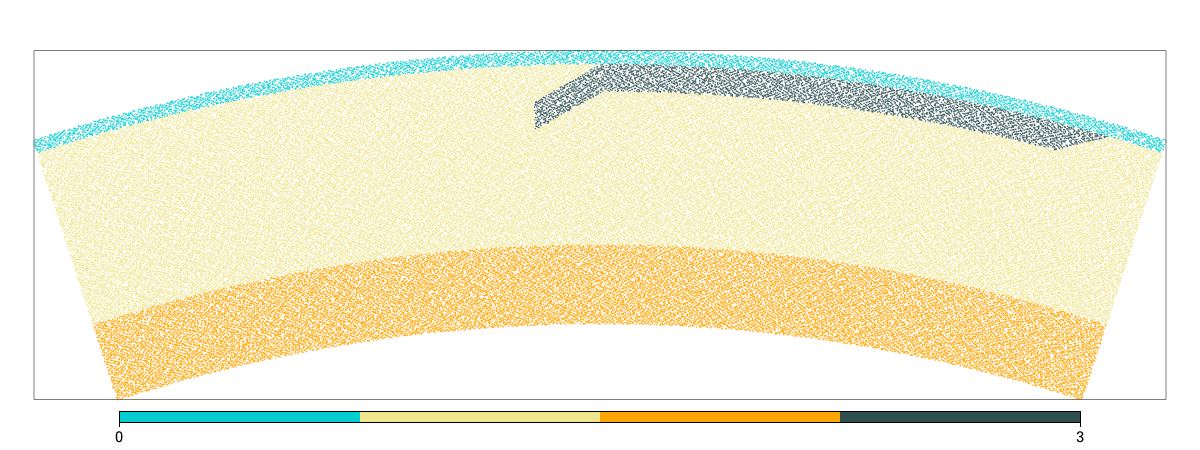

In [119]:
figP.show()

In [20]:
upperSurf = mesh.specialSets["upper_surface_VertexSet"]
lowerSurf = mesh.specialSets["lower_surface_VertexSet"]
rightSide = mesh.specialSets["MinJ_VertexSet"]
leftSide = mesh.specialSets["MaxJ_VertexSet"]
cEdge = (
    (upperSurf & rightSide)
    + (upperSurf & leftSide)
    + (lowerSurf & rightSide)
    + (lowerSurf & leftSide)
)


def setVbc():
    velocityField.data[...] = 0.0
    velocityField.data[upperSurf.data, :] = (0.0, 0.0)
    velocityField.data[lowerSurf.data, :] = (0.0, 0.0)
    velocityField.data[leftSide.data, :] = (0.0, 0.0)
    velocityField.data[rightSide.data, :] = (0.0, 0.0)


setVbc()

In [21]:
freeSlipAn = uw.conditions.RotatedDirichletCondition(
    variable=velocityField,
    indexSetsPerDof=(upperSurf + lowerSurf, rightSide + leftSide + cEdge),
    basis_vectors=(mesh.bnd_vec_normal, mesh.bnd_vec_tangent),
)


In [22]:
figVdot = glucifer.Figure(store=store, figsize=(1200, 450))
figVdot.append(
    glucifer.objects.Surface(
        mesh,
        fn.math.dot(velocityField, velocityField),
        # logScale=True,
        colours=glucifer.lavavu.matplotlib_colourmap("viridis"),
    )
)
if restartFlag is False:
    figVdot.save(outputDir + "/Vdot" + str(step).zfill(5))


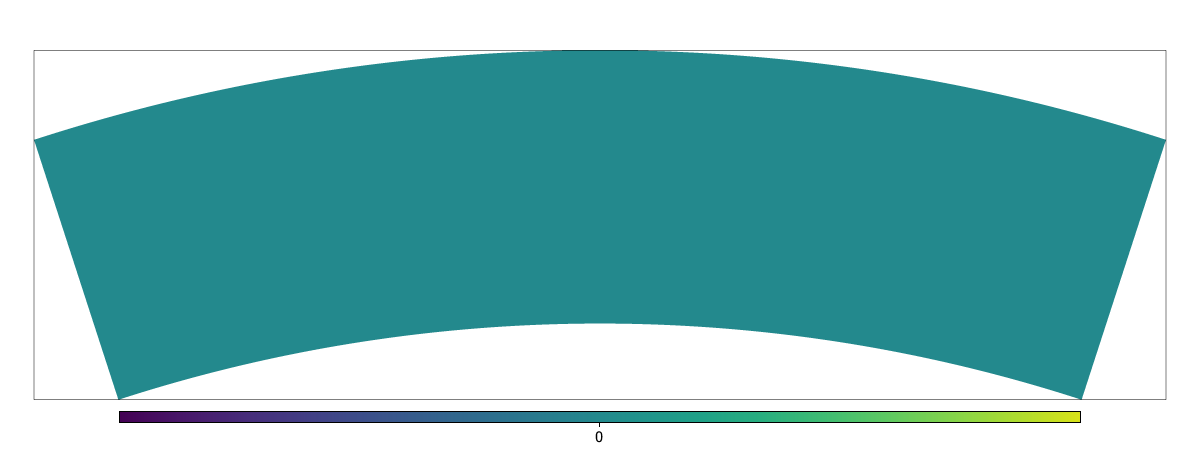

In [23]:
# figVdot.show()

In [24]:
airDensity = 0.0
mantleDensity = 0.000  # sh*t went crazy again
slabDensity = 1.00
densityMap = {0: airDensity, 1: mantleDensity, 2: mantleDensity, 3: slabDensity}
densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)
buoyancyFn = -1.0 * densityFn * mesh.unitvec_r_Fn

In [27]:
figD = glucifer.Figure(store=store, figsize=(1200, 450))
figD.append(glucifer.objects.Points(swarm, densityFn, colours="spectral", pointsize=2))
if restartFlag is False:
    figD.save(outputDir + "/Den")

figbuoyancy = glucifer.Figure(figsize=(1200, 450), name="Buoyancy Map")
figbuoyancy.Points(
    swarm,
    densityFn,
    pointsize=3,
    colours="(0.000)white (0.001)AntiqueWhite   (1.001)Gold"
    # colours=list(glucifer.lavavu.matplotlib_colourmap("Accent")),
)
if restartFlag is False:
    figbuoyancy.save(outputDir + "/BfnDot")


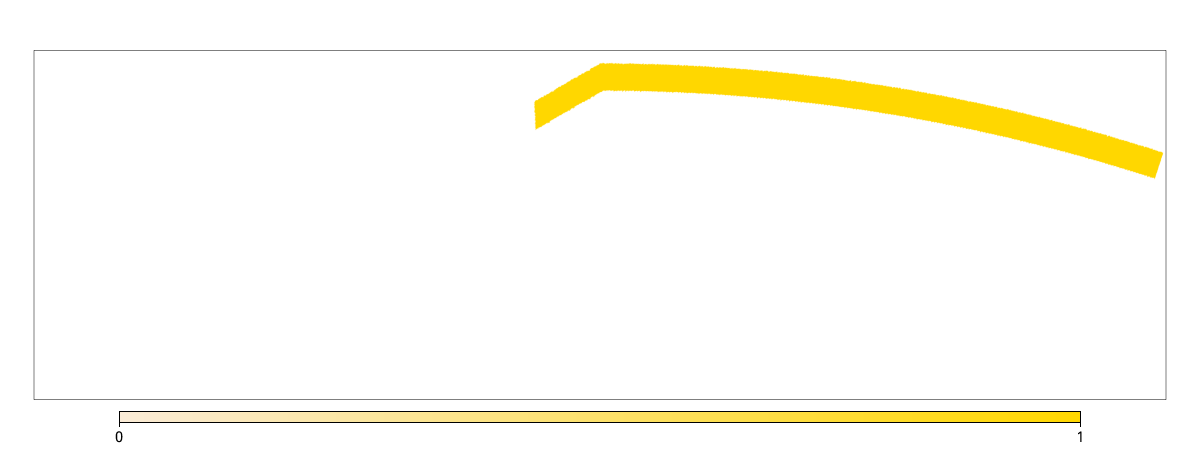

In [28]:
figbuoyancy.show()

In [31]:
airViscosity = 0.01  # This is Lekker!
mantleViscosity = 1.0
lowermantleViscosity = 1e2
slabViscosity = 5e2
viscosityMap = {
    0: airViscosity,
    1: mantleViscosity,
    2: lowermantleViscosity,
    3: slabViscosity,
}
swarmviscosityFn = fn.branching.map(fn_key=materialVariable, mapping=viscosityMap)
projVisMesh = uw.utils.MeshVariable_Projection(viscosityField, swarmviscosityFn, type=0)
projVisMesh.solve()

In [32]:
figV = glucifer.Figure(store=store, figsize=(1200, 450))
figV.append(
    glucifer.objects.Surface(
        mesh,
        viscosityField,
        logScale=True,
        colours=glucifer.lavavu.matplotlib_colourmap("inferno_r"),
    )
)
if restartFlag is False:
    figV.save(outputDir + "/eta" + str(step).zfill(5))


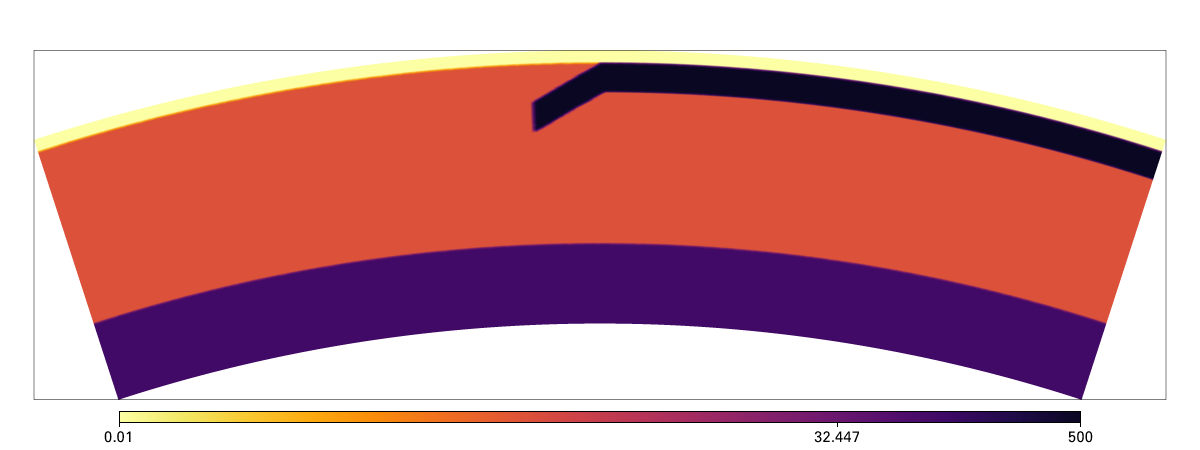

In [33]:
figV.show()

In [34]:
uw.mpi.barrier()
if restartFlag is False:
    checkpoint(
        mesh,
        fieldDict,
        swarm,
        swarmDict,
        index=step,
        modeltime=dm(time, 1.0 * u.megayear).magnitude,
        prefix=outputDir,
    )


Saving Mesh.....
Saving Swarm.....
Done.....


In [35]:
stokesSLE = uw.systems.Stokes(
    velocityField,
    pressureField,
    fn_viscosity=viscosityField,
    fn_bodyforce=buoyancyFn,
    conditions=freeSlipAn,
    _removeBCs=False,
)


stokesSolverAN = uw.systems.Solver(stokesSLE)

# stokesSolverAN.set_inner_method = "mumps"
stokesSolverAN.options.A11.ksp_type = "fgmres"
stokesSolverAN.options.scr.ksp_rtol = 1.0e-4
stokesSolverAN.options.scr.ksp_max_it = 100
# stokesSolverAN.options.scr.ksp_monitor = "ascii"
stokesSolverAN.options.scr.ksp_type = "fgmres"
stokesSolverAN.options.A11.ksp_rtol = 1.0e-5
# stokesSolverAN.options.A11.ksp_monitor = "ascii"

stokesSolverAN.set_penalty(100.0)
stokesSolverAN.options.main.restore_K = True
stokesSolverAN.options.main.force_correction = True
stokesSolverAN.options.main.Q22_pc_type = "gkgdiag"

stokesSolverAN.options.mg_accel.mg_accelerating_smoothing = True
stokesSolverAN.options.mg_accel.mg_smooths_to_start = 3
stokesSolverAN.options.mg_accel.mg_smooths_max = 10
stokesSolverAN.options.mg.mg_levels_ksp_convergence_test = "skip"
stokesSolverAN.options.mg.mg_levels_ksp_norm_type = "none"
stokesSolverAN.options.mg.mg_levels_ksp_max_it = 5
stokesSolverAN.options.mg.mg_levels_ksp_type = "chebyshev"
stokesSolverAN.options.mg.mg_coarse_pc_type = "lu"
stokesSolverAN.options.mg.mg_coarse_pc_factor_mat_solver_package = "mumps"


# stokesSolverAN.solve(print_stats=True, reinitialise=True)

In [36]:
def smooth_pressure():
    if uw.mpi.rank == 0:
        print("Smoothing Pressure...")
        sys.stdout.flush()

    Cell2Nodes.solve()
    Nodes2Cell.solve()


def pressure_calibrate():
    if uw.mpi.rank == 0:
        print("Calibration and Smoothing of PressureField... ")
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0 / area
    if uw.mpi.rank == 0:
        print("Zeroing pressure using mean upper surface pressure {}".format(offset))
    pressureField.data[:] -= offset
    smooth_pressure()
    if uw.mpi.rank == 0:
        print("Calibration and Smoothing of PressureField... Done")
    sys.stdout.flush()


def postSolve():
    # pressure_calibrate()
    # realign solution
    uw.libUnderworld.Underworld.AXequalsX(
        stokesSLE._rot._cself, stokesSLE._velocitySol._cself, False
    )
    # remove null space
    uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(
        stokesSLE._velocitySol._cself, stokesSLE._vnsVec._cself
    )

In [ ]:
while step < maxSteps:
    setVbc()  # seems important
    stokesSolverAN.solve(callback_post_solve=postSolve)
    # uw.libUnderworld.Underworld.AXequalsX(
    #     stokesSLE._rot._cself, stokesSLE._velocitySol._cself, False
    # )
    dt = advector.get_max_dt()
    advector.integrate(dt)
    swarm_popcontrol.repopulate()
    step += 1
    time += dt
    projVisMesh.solve()
    if step % 5 == 0 or step == 1 or step == 2:
        if store is not None:
            store.step = step
        figV.save(outputDir + "/eta" + str(step).zfill(5))
        figVdot.save(outputDir + "/Vdot" + str(step).zfill(5))
    if step % 10 == 0 or step == 1 or step == 2:
        checkpoint(
            mesh,
            fieldDict,
            swarm,
            swarmDict,
            index=step,
            modeltime=dm(time, 1.0 * u.megayear).magnitude,
            prefix=outputDir,
        )

if tflag:
    uw.timing.print_table(
        output_file=outputDir + "/uwTimer.log", display_fraction=0.999
    )

In [ ]:
figV.show()

In [ ]:
figVdot.show()